<a href="https://colab.research.google.com/github/JeanMusenga/PhD-Thesis_2024_Musenga/blob/main/BERT_ARPs_Classification_With_PredictionMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://chatgpt.com/share/b8196226-48d6-49a4-b448-db1ac491d8a5

https://chatgpt.com/share/d4841f05-7b85-45ea-ae25-470f9c2482d0

In [ ]:
pip install datasets

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
from datasets import Dataset, load_metric
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [3]:
import numpy as np
np.random.seed(42) #The random seed helps in the reproduction of the results

# Load the dataset

In [4]:
# Load the dataset
file_path = '/content/posts.xlsx'
df = pd.read_excel(file_path)

In [5]:
df[df['Label'] ==1].count()

,0
Question_body,7466
Label,7466


In [6]:
df[df['Label'] ==0].count()

,0
Question_body,7466
Label,7466


# Split the dataset

In [7]:
# Split the data into training and testing sets
#https://chatgpt.com/share/2f5dfec4-026c-4017-944e-7720f539930f
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize the data

In [8]:
# Tokenize the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['Question_body'], padding='max_length', truncation=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Convert DataFrame to Dataset

In [9]:
# Convert DataFrame to Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [10]:
# Tokenize the dataset
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/11945 [00:00<?, ? examples/s]

Map:   0%|          | 0/2987 [00:00<?, ? examples/s]

In [11]:
# Rename label column to 'labels' for compatibility with the Trainer
train_dataset = train_dataset.rename_column("Label", "labels")
test_dataset = test_dataset.rename_column("Label", "labels")

In [12]:
# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Loading the BERT model

In [13]:
# Loading the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Define Training Arguments

In [14]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Initialize the Adam optimizer

In [15]:
# Initialize the Adam optimizer
adam_optimizer = optim.Adam(model.parameters(), lr=2e-5)

Initialize Trainer
The Trainer class is initialized with the model, training arguments, and datasets.

In [16]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    optimizers=(adam_optimizer, None)
)

# Train the Model
The train method is called to start the training process.

In [17]:
trainer.train()

Step,Training Loss
10,0.678700
20,0.682500
30,0.665300
40,0.610200
50,0.593100
60,0.591900
70,0.482100
80,0.504600
90,0.444600
100,0.431900


TrainOutput(global_step=4482, training_loss=0.10737983161857412, metrics={'train_runtime': 3532.1527, 'train_samples_per_second': 10.145, 'train_steps_per_second': 1.269, 'total_flos': 9428584668825600.0, 'train_loss': 0.10737983161857412, 'epoch': 3.0})

# Evaluate the model
The evaluate method is called to evaluate the model on the test dataset.


In [18]:
# Evaluate the model
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = test_dataset['labels'].numpy()

In [26]:
# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])
accuracy = accuracy_score(y_true, y_pred)

In [27]:
print(f'Accuracy: {accuracy}')
print(f'Class 0 - Precision: {precision[0]}, Recall: {recall[0]}, F1 score: {f1[0]}')
print(f'Class 1 - Precision: {precision[1]}, Recall: {recall[1]}, F1 score: {f1[1]}')

Accuracy: 0.9742216270505524
Class 0 - Precision: 0.9903780068728523, Recall: 0.9581117021276596, F1 score: 0.9739776951672863
Class 1 - Precision: 0.9588772845953003, Recall: 0.9905596763317599, F1 score: 0.9744610281923716


In [28]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Calculate overall accuracy
overall_accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()

# Print class-specific metrics
print(f'Class 0 - Precision: {precision_class[0]:.4f}, Recall: {recall_class[0]:.4f}, F1-score: {f1_class[0]:.4f}, Support: {support_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]:.4f}, Recall: {recall_class[1]:.4f}, F1-score: {f1_class[1]:.4f}, Support: {support_class[1]}')

# Print overall accuracy
print(f'Overall Accuracy: {overall_accuracy:.4f}')


Class 0 - Precision: 0.9904, Recall: 0.9581, F1-score: 0.9740, Support: 1504
Class 1 - Precision: 0.9589, Recall: 0.9906, F1-score: 0.9745, Support: 1483
Overall Accuracy: 0.9742


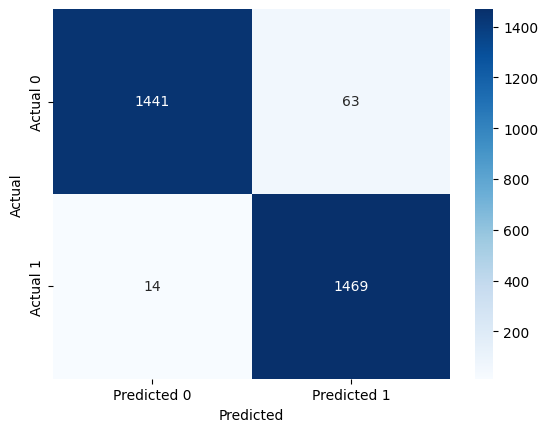

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Evaluate the model
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions  # This should be the raw prediction probabilities
y_true = test_dataset['labels'].numpy()

# Assuming binary classification with probabilities for both classes
# Use the probability of the positive class (index 1) for ROC calculation
y_pred_prob = y_pred[:, 1]  # Extracting the probabilities for the positive class

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)  # Optional: Add grid for better readability
plt.show()


# Save the model and tokenizer

The model and tokenizer are saved in the directory you specify in the save_pretrained method. In the code example provided, the model and tokenizer are saved in the ./saved_model directory relative to the current working directory where the script is executed

In [22]:
saved_model_path = './saved_model'
model.save_pretrained(saved_model_path)
tokenizer.save_pretrained(saved_model_path)

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

# List the contents of the saved model directory
You can verify the saved files by checking the ./saved_model directory. This directory should contain the following files:
config.json: Configuration file for the model.
pytorch_model.bin: The model's weights.
tokenizer_config.json: Configuration file for the tokenizer.
vocab.txt: Vocabulary file used by the tokenizer.
special_tokens_map.json

# //////////////To trust the prediction results of a BERT model//////////////////
To trust the prediction results of a BERT model (or any machine learning model), you should evaluate its performance using various metrics and techniques. Here are some steps to help you build confidence in the model's predictions:

# Learning Curves
Plot learning curves to see how the model's performance evolves with the amount of training data and epochs.

# Confusion Matrix
A confusion matrix provides a visual representation of the model's performance by showing the counts of true positive, true negative, false positive, and false negative predictions.

In [23]:
import os
print("Saved model files:", os.listdir(saved_model_path))

# Load the model and tokenizer
loaded_model = BertForSequenceClassification.from_pretrained(saved_model_path)
loaded_tokenizer = BertTokenizer.from_pretrained(saved_model_path)

Saved model files: ['special_tokens_map.json', 'config.json', 'model.safetensors', 'tokenizer_config.json', 'vocab.txt']


In [ ]:
import matplotlib.pyplot as plt

# Assuming training and validation losses are recorded as lists
# Ensure that `train_loss`, `val_loss`, and `logging_steps` have been collected during training.

plt.figure(figsize=(10, 6))  # Optional: Make the plot larger
plt.plot(logging_steps, train_loss, label='Training Loss', color='blue', marker='o')  # Added color and marker for clarity
plt.plot(logging_steps, val_loss, label='Validation Loss', color='orange', marker='x')  # Added color and marker for clarity
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')  # Optional: Add a title
plt.legend()
plt.grid(True)  # Optional: Add a grid for better readability
plt.show()


# Cross-Validation
Use cross-validation to assess the model's performance across different subsets of the data, ensuring that the evaluation is robust and not biased by a particular train-test split.

In [ ]:
from sklearn.model_selection import cross_val_score
from transformers import BertForSequenceClassification

# Assuming you have a scikit-learn compatible pipeline
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# Use cross_val_score with a compatible classifier pipeline
scores = cross_val_score(your_pipeline, X, y, cv=10, scoring='accuracy')
print(f'Cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean()}')

# Model explanation

In [ ]:
pip install shap
import shap

# Assuming you have a trained model and a tokenizer
explainer = shap.Explainer(model, tokenizer)
shap_values = explainer(test_dataset)
shap.summary_plot(shap_values, test_dataset)